In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

import src.configs.visualization_configs as visc
from src.visualization.plot import (
    image_concat_and_imshow,
    plot_scatter,
    set_mpl_styles,
)

In [2]:
set_mpl_styles()

In [15]:
cfg = visc.VisConfigs.load("../models/VBGMM/2024-12-03/13-52-15/config.yaml")
figure_dstdir = (
    Path("../reports/figures/")
    / "VBGMM"
    / cfg.clustering.run_datetime
    / cfg.clustering.model_name
)
features_srcdir = (
    Path("../reports/features/")
    / cfg.extraction.model_name
    / cfg.extraction.run_datetime
)
from_data = "train"
filename = f"features_{from_data}_data"
filename_with_clusters = (
    f"{filename}_pca_with_clusters_"
    f"{cfg.clustering.run_datetime.replace('/', '-')}"
)

In [16]:
df_original = pl.read_csv(features_srcdir/(filename + ".csv"))

In [17]:
df_pca = pl.read_csv(features_srcdir / (filename_with_clusters + ".csv"))
clusters = df_pca.select("cluster").unique().to_numpy().flatten()
print(clusters)
# features = df.select("column_1", "column_2")

[0 1 2 3]


In [18]:
df_pca.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,filepath,cluster
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64
0.173142,0.162529,-0.109597,1.0825,-2.111666,0.151749,-1.394799,0.678353,1.393868,1.131281,0.492683,0.664322,0.166087,0.03436,-0.584433,-0.317119,0.250662,0.104977,-0.533719,0.161172,-0.081432,-0.289808,-0.265879,-0.111532,-0.207722,-0.049444,-0.189778,-0.099893,-0.087501,-0.024487,-0.166391,-0.064073,"""0/10k_0_h000_w…",3
-1.051695,-1.104278,0.52337,-0.003504,-0.815578,-0.650353,0.270164,-0.475999,-0.305822,1.390778,-0.182352,-0.119078,-0.285417,-0.180663,0.165322,0.044547,-0.445712,0.047104,0.188768,0.106351,0.073241,-0.037912,-0.008698,-0.050499,-0.058883,0.067835,-0.006983,0.043306,-0.042546,-0.008804,-0.049593,0.009913,"""0/10k_0_h000_w…",3
0.803667,-0.004761,-0.131753,-0.046982,0.380215,-0.289218,-1.229359,0.018727,0.354887,1.00605,-0.029974,-0.083289,-0.020732,0.096878,0.247201,-0.106786,-0.1283,0.029386,0.003369,-0.169002,-0.067621,-0.037872,0.124562,0.063855,0.051,-0.075388,0.006384,0.015067,0.021354,0.011127,-0.022712,0.00439,"""0/10k_0_h000_w…",3
0.101997,-1.183412,-0.826398,-0.43978,0.386907,-0.142309,-1.107034,0.074238,-0.208011,1.583003,-0.720771,-0.080745,0.126707,0.185921,-0.061193,-0.007809,-0.239543,0.19463,-0.151609,-0.002257,-0.062258,-0.02582,0.103826,0.067607,0.111623,-0.049027,-0.048583,0.073141,-0.006388,-0.011327,-0.023349,0.00322,"""0/10k_0_h000_w…",3
-1.514246,-2.112584,-0.025551,0.218504,-0.67938,-0.88177,0.348873,-0.367432,-0.740289,1.343267,-0.648274,0.20587,-0.299062,-0.196518,0.086899,-0.017917,-0.21854,0.242757,0.1965,-0.00232,0.108483,-0.116362,0.073894,-0.010853,0.013829,0.090187,0.004463,-0.013372,-0.036859,-0.015258,0.00642,0.023749,"""0/10k_0_h000_w…",3


In [19]:
datas: dict[float, np.ndarray] = {
    cluster: df_pca.filter(pl.col("cluster") == cluster)
    .select("column_0", "column_1")
    .to_numpy()
    for cluster in clusters
}

In [20]:
for c, v in datas.items():
    print(f"cluster {c} size is {len(v)}")

cluster 0 size is 1242
cluster 1 size is 1631
cluster 2 size is 4416
cluster 3 size is 34660


In [21]:
print(figure_dstdir)

../reports/figures/VBGMM/2024-12-03/13-52-15/vbgmm_pca_4_4clusters


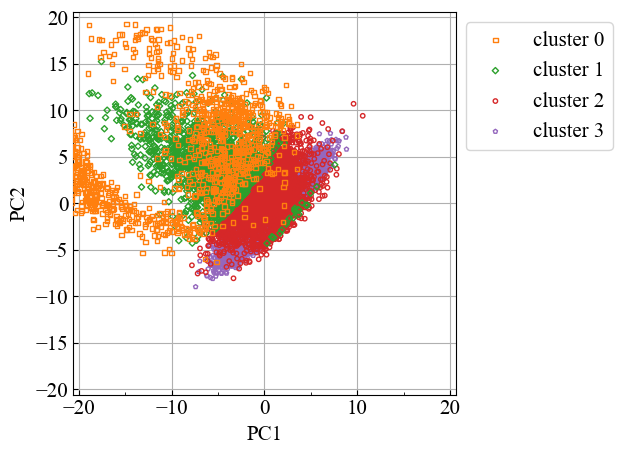

In [25]:
cmap = plt.get_cmap("tab10")
markers = ["s", "D", "o", "p", "*", "h", "D", "8", "v", "x"]


fig = plt.figure(layout="tight")
ax = fig.add_subplot()

path_collections = {
    cluster: plot_scatter(
        data.T, size=10, marker=markers[cluster], color=cmap(cluster+1), ax=ax,
    )[-1]
    for cluster, data in datas.items()
}

num_clusters = len(datas)
for i, (c, pc) in enumerate(path_collections.items()):
    pc.set_label(f"cluster {c}")
    pc.set_zorder(num_clusters - i)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_xticks(np.arange(-20, 21, 5),minor=True)

if not figure_dstdir.exists():
    figure_dstdir.mkdir(parents=True)

fig.savefig(figure_dstdir / f"scatter_{cfg.clustering.model_name}.svg", dpi=350)
fig.savefig(figure_dstdir / f"scatter_{cfg.clustering.model_name}.png", dpi=350)

In [23]:
for u, *_ in df_pca.select("cluster").unique().iter_rows():
    print(u)

0
1
2
3


0: len(imgs)=16
1: len(imgs)=16
2: len(imgs)=16
3: len(imgs)=16


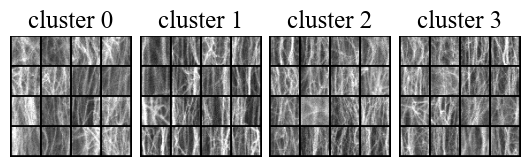

In [24]:
imgs, dddf = image_concat_and_imshow(
    df_pca,
    col_row=(4,4),
    # labels = list(datas.keys()),
    image_root="../data/processed/CNTForest/cnt_sem_32x32/10k",

)

In [26]:
for i, img in enumerate(imgs):
    img.save(figure_dstdir / f"structure_cluster{i}.png")

In [27]:
dddf.write_csv(figure_dstdir / "concated_image_number.csv")